In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats as scp
from collections import Counter
from sklearn.cluster import KMeans

In [ ]:
def toBinary(threshold, element):
    return 1 if element > threshold else 0

npToBinary = np.vectorize(toBinary, otypes=[np.uint8])

In [ ]:
def filterNoiseAndBG(size):
    return size > 50 and size < 10000

In [ ]:
def classify(clustersNumber, centroidMean, counter):
    
    if clustersNumber == 1:    
        if centroidMean > 1000:
            pecas["porcas"] = 0
            pecas["parafusos"] = counter.get(0)
            return pecas
        
        pecas["porcas"] = counter.get(0)
        pecas["parafusos"] = 0
        return pecas
    pecas["porcas"] = counter.get(0)
    pecas["parafusos"] = counter.get(1)
    return pecas

In [ ]:
pathList = list()
for path, subdirs, files in os.walk(r"/home/martin/Downloads/uninove/"):
    for file in files:
        if 'jpg' in file:
            currentFilePath = "".join(path) + file
            pathList.append(currentFilePath)
pathList = sorted(pathList)

In [147]:
def analyzeImage(limiarBase, caminhoImagem):

    LIMIAR = limiarBase
    contador = None
    pecas = dict()
    CLUSTERS = 2

    testImage = cv.imread(caminhoImagem, cv.IMREAD_GRAYSCALE)

    while True:

        binaryImage = npToBinary(LIMIAR, testImage)

        nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(binaryImage, 8, cv.CV_32S)

        # só estamos interessados na coluna de aŕea total do componente conexo
        areaSlice = stats[:, cv.CC_STAT_AREA]

        # realizamos o sort para que se possa remover valores incorretos, 
        # como áreas muito pequenas ou o background
        areaArray = np.sort(np.asarray(list(filter(filterNoiseAndBG, areaSlice))))
        areaArray = areaArray.reshape(areaArray.size, 1)
    
        if areaArray.std() < 100:
            CLUSTERS = 1

        # se tivermos um desvio padrão elevado, significa que estamos
        # lidando tanto com porcas quanto parafusos
        initializationArray = None
        if areaArray.std() < 100:
            initializationArray = np.array([[500]])
            CLUSTERS = 1
        else:
            initializationArray = np.array([[400], [1500]])

        kmeans = KMeans(n_clusters=CLUSTERS, max_iter=50, n_init=1,init=initializationArray).fit(areaArray)
        contador = Counter(kmeans.labels_)

        # caso não exista marcamos como 0
        pecas = classify(centroidMean=kmeans.cluster_centers_, clustersNumber=CLUSTERS, counter=contador)

        if LIMIAR > 250:
            raise Exception("LIMIAR maior que 250")
            break

        if pecas["porcas"] > 10 or pecas["parafusos"] > 10:
            LIMIAR += 5
        elif pecas["porcas"] < 11 or pecas["parafusos"] < 11:
            return (pecas, LIMIAR)

In [149]:
parafusos = [10,10,10,5,9,10,7,7,10,10,10,10,10,10,9,0,7,10,7,10,10,10,8,9,10]
porcas = [10,10,10,10,9,10,10,10,10,9,0,10,9,10,10,10,7,10,9,10,10,10,8,10,9]

acertosParafusos = 0
acertosPorcas = 0
acertos = 0

for index, imagePath in enumerate(pathList):
    
    if index == 12:
        continue
        
    baseLimiar = 150
    pecas, LIMIAR = analyzeImage(baseLimiar, imagePath)
    
    contPorcas = pecas["porcas"]
    contParafusos = pecas["parafusos"]
    
    if (porcas[index] == contPorcas):
        acertosPorcas += 1
    if (parafusos[index] == contParafusos):
        acertosParafusos += 1
    if (porcas[index] == contPorcas and parafusos[index] == contParafusos):
        acertos += 1
    
    print("INFO; Imagem No", index)
    print("Imagem: ", imagePath)
    print("Limiar: {}. No Porcas: {}, No Parafusos: {}".format(LIMIAR, contPorcas, contParafusos))
    print("Número correto de porcas: {}, parafusos: {}".format(porcas[index], parafusos[index]))
    print("\nTaxa de acertos (Parafusos):", round((acertosParafusos/len(porcas)*100),2))
    print("Taxa de acertos (Porcas): ", round((acertosPorcas/len(porcas)*100),2))
    print("Taxa de acertos:", round((acertos/25*100),2))
    print("----------")

INFO; Imagem No 0
Imagem:  /home/martin/Downloads/uninove/img01.jpg
Limiar: 150. No Porcas: 10, No Parafusos: 10
Número correto de porcas: 10, parafusos: 10

Taxa de acertos (Parafusos): 4.0
Taxa de acertos (Porcas):  4.0
Taxa de acertos: 4.0
----------
INFO; Imagem No 1
Imagem:  /home/martin/Downloads/uninove/img02.jpg
Limiar: 155. No Porcas: 10, No Parafusos: 10
Número correto de porcas: 10, parafusos: 10

Taxa de acertos (Parafusos): 8.0
Taxa de acertos (Porcas):  8.0
Taxa de acertos: 8.0
----------
INFO; Imagem No 2
Imagem:  /home/martin/Downloads/uninove/img03.jpg
Limiar: 150. No Porcas: 10, No Parafusos: 10
Número correto de porcas: 10, parafusos: 10

Taxa de acertos (Parafusos): 12.0
Taxa de acertos (Porcas):  12.0
Taxa de acertos: 12.0
----------
INFO; Imagem No 3
Imagem:  /home/martin/Downloads/uninove/img04.jpg
Limiar: 170. No Porcas: 10, No Parafusos: 5
Número correto de porcas: 10, parafusos: 5

Taxa de acertos (Parafusos): 16.0
Taxa de acertos (Porcas):  16.0
Taxa de acert

514.7333017030141 924.0952380952381
[[ 443.81818182]
 [1452.4       ]]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Counter({0: 11, 1: 10})


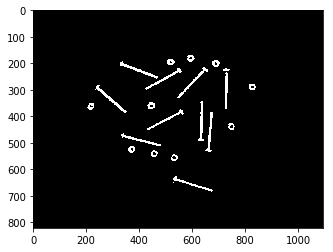

In [145]:
currentImage = "/home/martin/Downloads/uninove/img14.jpg"
testImage = cv.imread(currentImage, cv.IMREAD_GRAYSCALE)
CLUSTERS = 2

# imagem convertida para binário
binaryImage = npToBinary(180, testImage)

nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(binaryImage, 8, cv.CV_32S)

# só estamos interessados na coluna de aŕea total do componente conexo
areaSlice = stats[:, cv.CC_STAT_AREA]

# filtramos ruidos e o fundo da imagem, e então transformamos o vetor
# para que seja conforme o parâmetro do kmeans
areaArray = np.sort(np.ndarray.flatten(np.asarray(list(filter(filterNoiseAndBG, areaSlice)))))
areaArray = areaArray.reshape(areaArray.size, 1)

# se tivermos um desvio padrão elevado, significa que estamos
# lidando tanto com porcas quanto parafusos
initializationArray = None
if areaArray.std() < 100:
    initializationArray = np.array([[500]])
    CLUSTERS = 1
else:
    initializationArray = np.array([[300], [1500]])
    
print(areaArray.std(), areaArray.mean())

kmeans = KMeans(n_clusters=CLUSTERS, max_iter=50, n_init=1,init=initializationArray).fit(areaArray)

print(kmeans.cluster_centers_)
print(kmeans.labels_)
contador = Counter(kmeans.labels_)
print(contador)


plt.imshow(binaryImage, cmap="gray")

In [ ]:
list(filter(filterNoiseAndBG, [300, 10, 200, 90000]))